# Background:
Reproduce the results in Ref: Physics-informed echo state networks (Doan, 2020)

**Parameters:**

**Lorenz:**
- $dt = 0.01$, $N_t = 1000$, largest LE: $\lambda = 0.934$

Reservoir:
- $\sigma_{in} = 0.15$, spectral Radius: $\Lambda = 0.4$, avg. Deg: $<d>=3$, reg. Param: $\gamma=0.0001$

PI-ESN:
- prediction horizon: $N_p = 1000$

**Charney-DeVore system:**
- $dt = 0.1$, largest LE: $\lambda = 0.033791$

Reservoir:
- $\sigma_{in} = 2.0$, spectral Radius: $\Lambda = 0.9$, avg. Deg: $<d>=3$, reg. Param: $\gamma=0.0001$
PI-ESN:
- prediction horizon: $N_p = 3000$

**PI-ESN Training:**

Option 1:
- Train RC for $N_t$ timesteps $\rightarrow$ get $W_{out, 0}$
- As a function of $W_{out}$:
    - Run the pretrained RC for $N_p$ timesteps in loop (i.e. prediction mode) $\rightarrow$ get $\{\hat{y}_i\}$
    - Calculate the Error $E_p = \sum_i^{N_p} ||F(\hat{y}_i) - \dot\hat{y}_i||^2$
- Note:
    - Copy the state of the pre trained RC

Option 2:
- Drive the Reservoir for $N_t + N_p$ time steps $\rightarrow$ obtain $\{ r_i \}_{i=1}^{N_p + N_t}$
- Minimize the error: $$ E_{tot}(W_{out}) = E_d + E_p $$

# Imports:

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)
import rescomp

# new imports:
import rescomp.lyapunov_analysis as la

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lorenz iterator:

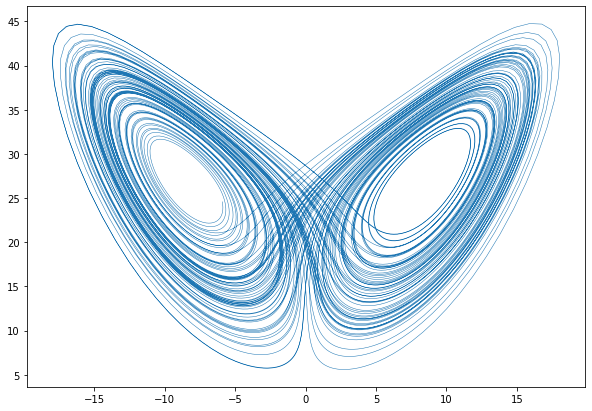

In [65]:
# Lorenz parameters:
dt_L = 0.01
lyap_L = 0.934
starting_point_L = np.array([0, 1, 0])
# starting_point_L = np.array([-14.03020521, -20.88693127, 25.53545])

# lorenz iterator:
def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 10000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series = time_series_all[disc_steps:, :]

plt.plot(time_series[:, 0], time_series[:, 2], linewidth=0.5)

# Create the ESN architecture:

In [98]:
esn = rescomp.ESNWrapper()
# esn.set_console_logger("debug")
esn.create_architecture(200, 3, w_out=None, seed=9, w_out_fit_flag="linear_and_square_r_alt", leak_fct=0.0,
                        activation_function="tanh", n_rad=0.4, w_in_scale=0.15, n_avg_deg=3)
esn.summary()

INPUT: 
x_dim: 3
INPUT-RESERVOIR COUPLING W_in: 
W_in: (200, 3)
- - - - - - - - - - -
w_in_scale: 0.15, w_in_sparse: True, w_in_ordered: False
RESERVOIR: 
- - - - - - - - - - -
Network: 
n_dim: 200
n_rad: 0.4, n_avg_deg: 3, n_type_flag: erdos_renyi, 
- - - - - - - - - - -
Dynamics: 
act_fct_flag: tanh, bias_scale: 0, leak_factor: 0.0
Update equation: r(i+1) = leak_fct * r(i) + (1-leak_fct) * act_fct(W_in * x(i) + W * r(i))
NON-LINEAR TRANSFORM OF RESERVOIR STATE: 
w_out_fit_flag: linear_and_square_r_alt
RESERVOIR-OUTPUT COUPLING W_out: 
W_out: (3, 200)



In [99]:
# create w_out_init:
train_steps = 1000
sync_steps = 300

esn.reset_res_state()

esn.train(x_train=time_series[:sync_steps + train_steps], sync_steps=sync_steps, reg_param=0.0001, w_in_no_update=True)
y_pred_0, y_test_0 = esn.predict(time_series[sync_steps + train_steps-1:], save_r=False)
w_out_init = esn.get_w_out()

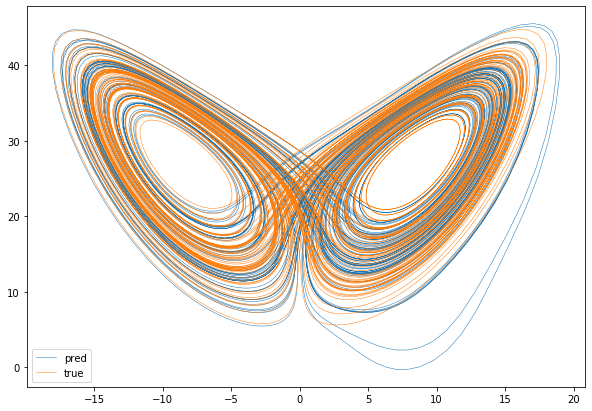

In [100]:
plt.plot(y_pred_0[:, 0], y_pred_0[:, 2], linewidth=0.5, label="pred")
plt.plot(y_test_0[:, 0], y_test_0[:, 2], linewidth=0.5, label="true")
plt.legend()

In [101]:
def Lorenz_model_array(x):
    sigma=10
    rho=28
    beta=8/3
    return np.array([sigma * (x[:, 1] - x[:, 0]),
                 x[:, 0] * (rho - x[:, 2]) - x[:, 1],
                 x[:, 0] * x[:, 1] - beta * x[:, 2]]).T

def physical_error(y_pred, model, dt):
    y_pred_grad = (y_pred[1:] - y_pred[:-1])/dt
    y_pred_grad_model = model(y_pred)[:-1]

    F = y_pred_grad - y_pred_grad_model

    E = np.mean(np.linalg.norm(F, axis=1))
    return E
    # return y_pred_grad, y_pred_grad_model

def physical_error_esn(w_out, esn_trained, time_series, steps, sync_steps, model, wout_shape, dt):
    esn_trained.set_console_logger("off")
    esn = esn_trained
    esn.reset_res_state()
    # set w_out of esn:
    esn._w_out = w_out.reshape(wout_shape)

    # synchronize:
    esn.synchronize(time_series[:sync_steps, :])

    # predict:
    y_pred, y_test = esn.predict(time_series[sync_steps-1:sync_steps+steps], save_r=False)
    # return y_pred, y_test

    # Calculate the error from y_pred:
    E = physical_error(y_pred, model, dt)
    print(E)
    return E

def minimize_physical_error(w_out_init, esn_trained, time_series, steps, sync_steps, model, wout_shape, dt, **kwargs):
    w_out_init_flat = w_out_init.flatten()
    args = (esn_trained, time_series, steps, sync_steps, model, wout_shape, dt)
    opt_results = scipy.optimize.minimize(fun=physical_error_esn, x0=w_out_init_flat,
                                                  args=args, **kwargs)
    return opt_results

In [114]:
sync_steps = 300
steps = 1000
wout_shape = (3, 200)
model = Lorenz_model_array
method = "L-BFGS-B"
out = minimize_physical_error(w_out_init, esn, time_series, steps, sync_steps, model, wout_shape, dt_L,
                              method=method, options={"disp": True, "maxiter": 10})

5.2289796648028375
5.228989794829643
5.22898272945619
5.228992571851593
5.228975403079349
5.228979607509453
5.228990447354788
5.22898867071644
5.228978692712838
5.228979774256729
5.228990406858766
5.2289692769895355
5.228992594004437
5.228970724417926
5.228992774300735
5.2289770085584815
5.228979194628194
5.22897925960164
5.228976138732039
5.228979150582505
5.228978874618695
5.228985137026316
5.228976755414246
5.228991245189943
5.22898423999218
5.228971056729202
5.2289734314492105
5.228981938582146
5.228991131176691
5.228975392359545
5.228982975537745
5.228973028705215
5.228984464574026
5.2289685269305215
5.228985450072637
5.228981397917199
5.228978941929366
5.228971553398004
5.22898385289645
5.228970406484485
5.228992350156482
5.228978204779961
5.228983720327248
5.228968888882099
5.228974640913578
5.22897420488341
5.228974171892041
5.228971492472845
5.22898117549867
5.228991153316878
5.228974127161856
5.228982339120097
5.228978646669952
5.228988047562211
5.2289683201190735
5.228970063

# Test optimized vs. initial predictions:

In [115]:
sync_steps = 300
steps = 5000

In [116]:
# optimized reservoir:
w_out_opt = out["x"].reshape(wout_shape)
esn.reset_res_state()
esn._w_out = w_out_opt
# synchronize:
esn.synchronize(time_series[:sync_steps, :])
# predict:
y_pred_opt, y_test_opt = esn.predict(time_series[sync_steps-1:sync_steps+steps], save_r=False)

In [117]:
# initial reservoir:
esn.reset_res_state()
esn._w_out = w_out_init
# synchronize:
esn.synchronize(time_series[:sync_steps, :])
# predict:
y_pred_init, y_test_init = esn.predict(time_series[sync_steps-1:sync_steps+steps], save_r=False)

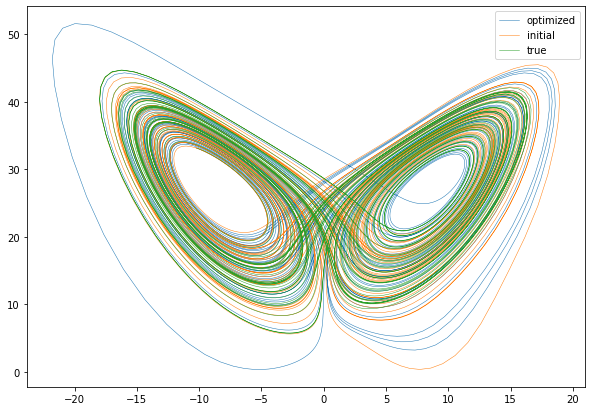

In [118]:
y_test = y_test_init # its the same as y_test_opt
plt.plot(y_pred_opt[:, 0], y_pred_opt[:, 2], linewidth=0.5, label="optimized")
plt.plot(y_pred_init[:, 0], y_pred_init[:, 2], linewidth=0.5, label="initial")
plt.plot(y_test[:, 0], y_test[:, 2], linewidth=0.5, label="true")
plt.legend()

(0, 2000)

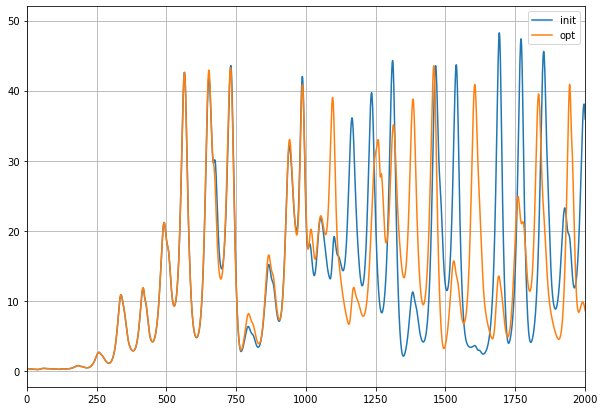

In [119]:
# plot the error over time:
error_init = rescomp.measures.error_over_time(y_pred_init, y_test)
error_opt = rescomp.measures.error_over_time(y_pred_opt, y_test)
plt.plot(error_init, label="init")
plt.plot(error_opt, label="opt")
plt.grid()
plt.legend()
plt.xlim(0, 2000)

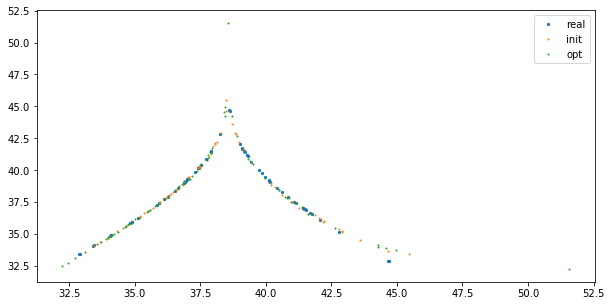

In [120]:
# Poincare Map:
ix = 2
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=5)

x, y = rescomp.measures.poincare_map(y_pred_init, dimension=ix, mode=mode)
plt.scatter(x, y, label="init", s=1)

x, y = rescomp.measures.poincare_map(y_pred_opt, dimension=ix, mode=mode)
plt.scatter(x, y, label="opt", s=1)

plt.legend()

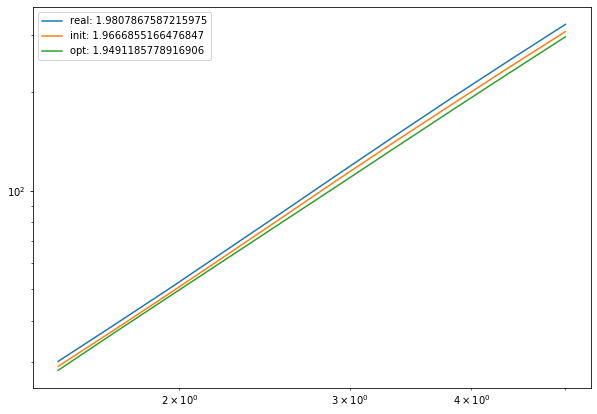

In [121]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred_init, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"init: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred_opt, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"opt: {sloap}")

plt.legend()

In [110]:
np.linalg.norm(w_out_init - w_out_opt)

8.387340043874208e-07

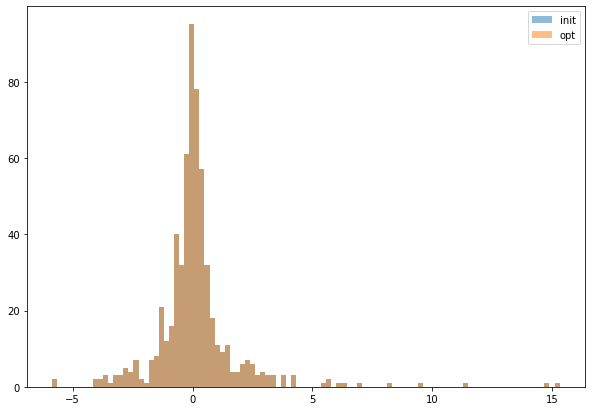

In [122]:
# compare the different: w_outs:
plt.hist(w_out_init.flatten(), bins=100, alpha=0.5, label="init")
plt.hist(w_out_opt.flatten(), bins=100, alpha=0.5, label="opt")
plt.legend()

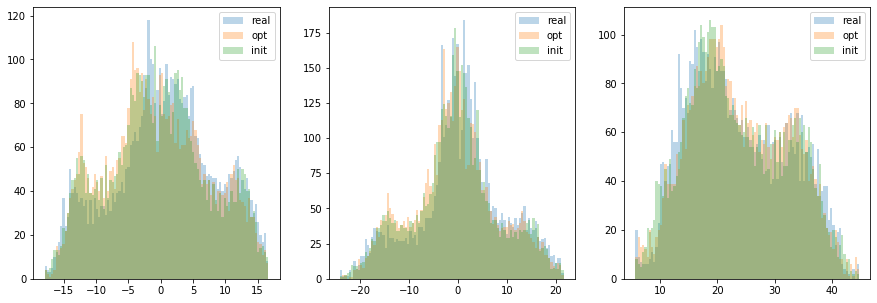

In [123]:
# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred_opt[:, ix], bins=b, alpha=0.3, label="opt")
plt.hist(y_pred_init[:, ix], bins=b, alpha=0.3, label="init")
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred_opt[:, ix], bins=b, alpha=0.3, label="opt")
plt.hist(y_pred_init[:, ix], bins=b, alpha=0.3, label="init")
plt.legend()

plt.subplot(133)
ix = 2
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred_opt[:, ix], bins=b, alpha=0.3, label="opt")
plt.hist(y_pred_init[:, ix], bins=b, alpha=0.3, label="init")
plt.legend()

# Simple ESN:

In [101]:
train_steps = 5000
sync_steps = 100

# create network:
esn = rescomp.ESNWrapper()

np.random.seed(40)
esn.create_network(n_dim=500, n_rad=0.4, n_avg_deg=3,
                    n_type_flag="erdos_renyi", network_creation_attempts=10)

x_dim = time_series.shape[1]
esn.create_input_matrix(x_dim, w_in_scale=0.15, w_in_sparse=True, w_in_ordered=False)

# train and predict:

esn.train(x_train=time_series, sync_steps=sync_steps, reg_param=0.0001,               w_in_no_update=True, w_out_fit_flag="simple")

# y_pred, y_test = esn.train_and_predict(time_series, train_sync_steps=sync_steps, train_steps=train_steps,
#                                        w_out_fit_flag="simple", reg_param=0.0001)

In [182]:
esn = rescomp.ESNWrapper()
esn.set_console_logger("debug")
esn.create_architecture(500, 3, res_state=np.random.randn(500), w_out=np.random.randn(3, 500)*0.1, seed=10, w_out_fit_flag="simple", leak_fct=0.9)

03-06 16:20:49 [DEBUG  ] Create network
03-06 16:20:50 [DEBUG  ] Create w_in
03-06 16:20:50 [DEBUG  ] Set activation function to flag: tanh_simple
03-06 16:20:50 [DEBUG  ] _w_out_fit_flag set to simple
03-06 16:20:50 [DEBUG  ] Setting self._w_out with the set_w_out function


In [183]:
esn.summary()

INPUT: 
x_dim: 3
INPUT-RESERVOIR COUPLING W_in: 
W_in: (500, 3)
- - - - - - - - - - -
w_in_scale: 1.0, w_in_sparse: True, w_in_ordered: False
RESERVOIR: 
- - - - - - - - - - -
Network: 
n_dim: 500
n_rad: 0.1, n_avg_deg: 6.0, n_type_flag: erdos_renyi, 
- - - - - - - - - - -
Dynamics: 
act_fct_flag: tanh_simple, bias_scale: 0, leak_factor: 0.9
Update equation: r(i+1) = leak_fct * r(i) + (1-leak_fct) * act_fct(W_in * x(i) + W * r(i))
NON-LINEAR TRANSFORM OF RESERVOIR STATE: 
w_out_fit_flag: simple
RESERVOIR-OUTPUT COUPLING W_out: 
W_out: (3, 500)



# PI-ESN:

In [ ]:
def physical_error(w_out, esn_trained, steps, model, w_shape, dt):
    # esn is pre-trained, but not necessarily synchronized
    # set w_out of esn:
    esn_trained._w_out = w_out.reshape(w_shape)


In [ ]:
train_steps = 1000
sync_steps = 10

# create network:
esn = rescomp.ESNWrapper()

np.random.seed(40)
esn.create_network(n_dim=200, n_rad=0.4, n_avg_deg=3,
                    n_type_flag="erdos_renyi", network_creation_attempts=10)

x_dim = time_series.shape[1]
esn.create_input_matrix(x_dim, w_in_scale=0.15, w_in_sparse=True, w_in_ordered=False)

# train and predict:
y_pred, y_test = esn.train_and_predict(time_series, train_sync_steps=sync_steps, train_steps=train_steps,
                                       w_out_fit_flag="simple", reg_param=0.0001)



# OLD:

# RC prediction:

In [2]:
train_steps = 2000
sync_steps = 300

# create network:
esn = rescomp.ESNWrapper()

np.random.seed(42)
esn.create_network(n_dim=500, n_rad=0.1, n_avg_deg=6.0,
                    n_type_flag="erdos_renyi", network_creation_attempts=10)

x_dim = time_series.shape[1]
esn.create_input_matrix(x_dim, w_in_scale=1.0, w_in_sparse=True, w_in_ordered=False)

# train and predict:
y_pred, y_test = esn.train_and_predict(time_series, train_sync_steps=sync_steps, train_steps=train_steps,
                                       w_out_fit_flag="linear_and_square_r_alt")

NameError: name 'rescomp' is not defined

# Compare real vs. predicted time_series:

In [20]:
time = np.arange(0, y_pred.shape[0])*dt_L

## small times:

(0, 15)

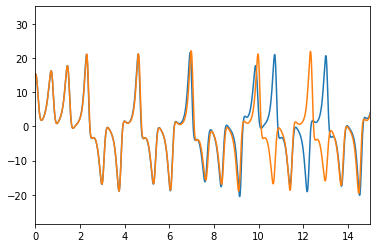

In [24]:
# Simple: plot some coordinates
ix = 1
plt.plot(time, y_test[:, ix])
plt.plot(time, y_pred[:, ix])

plt.xlim(0, 15)

(0, 15)

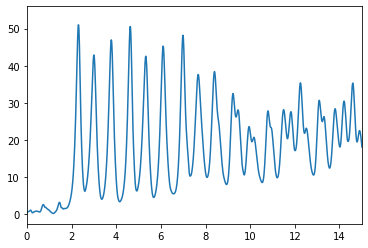

In [22]:
# plot the error over time:
error = rescomp.measures.error_over_time(y_pred, y_test)
plt.plot(time, error)
plt.xlim(0, 15)

## Attractor measures:

### Probability Density Function:

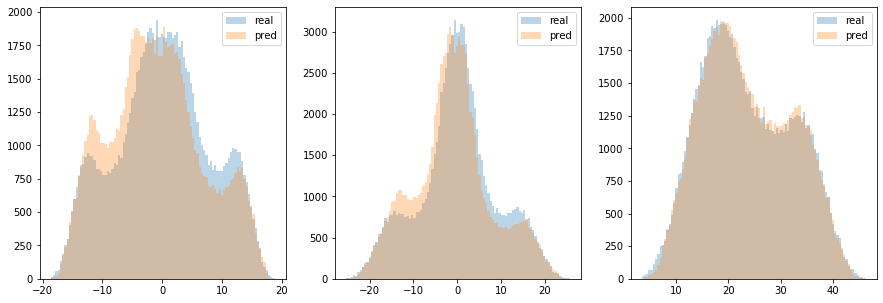

In [10]:
# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(133)
ix = 2
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

### Fourier Spectrum:

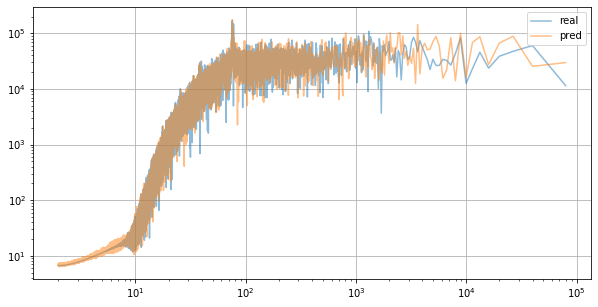

In [9]:
# Fourier Spectrum:
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(y_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(y_pred, period=True)
plt.plot(x,y, label="pred", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

### Poincare Map:

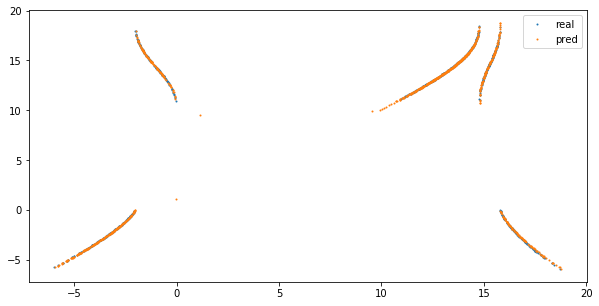

In [10]:
# Poincare Map:
ix = 0
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=1)

x, y = rescomp.measures.poincare_map(y_pred, dimension=ix, mode=mode)
plt.scatter(x, y, label="pred", s=1)

plt.legend()

### Correlation Dimension:

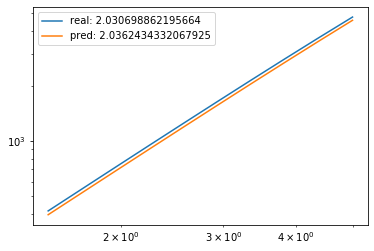

In [11]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"pred: {sloap}")

plt.legend()

### Lyapunov spectrum:

#### Rosenberg Algorithm:

avg period: 3.628044383186562
For 0/79700 points, all 50 closest neighbours were temporally closer than 3.628044383186562 and thus not considered
For 888/79700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 78812
avg period: 4.260265365622095
For 0/79700 points, all 50 closest neighbours were temporally closer than 4.260265365622095 and thus not considered
For 1095/79700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 78605


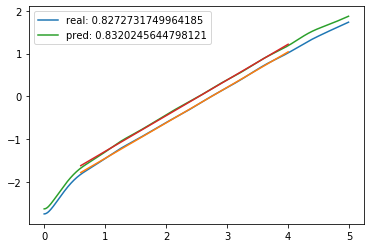

In [12]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(y_test, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(y_pred, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"pred: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

#### QR decomposition:

In [202]:
Nens = 5
N_dims = 5
np.random.seed(42)
starting_points = np.random.randn(Nens, 3)

In [14]:
# iterator of reservoir:
def f_res(x):
    return esn._predict_step(x)

In [204]:
out_real = rescomp.measures.calculate_divergence(f_L, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

out_res = rescomp.measures.calculate_divergence(f_res, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000
N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000


(0, 1)

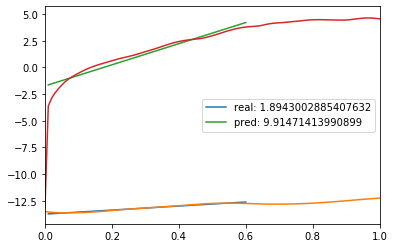

In [206]:
for out, label in zip((out_real, out_res), ("real", "pred")):
    y = np.log(out)
    y = np.mean(y, axis=-1)[:, 0]
    t = np.arange(0, y.size)*dt_L
    x_fit, y_fit, coef = rescomp.utilities._linear_fit(y, dt_L, t_min=0.01, t_max=0.6)
    plt.plot(x_fit, y_fit, label=f"{label}: {coef[0]}")
    plt.plot(t, y)
plt.legend()
plt.xlim(0, 1)

## Different inputs and synchronization:

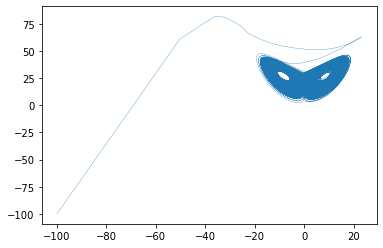

In [15]:
starting_point = np.array([-100, -100, -100])

# test lorenz iterator:
time_steps = 100000

time_series_2 = np.zeros((time_steps, 3))
time_series_2[0, :] = starting_point

res_results = np.zeros((time_steps, 500))

for i in range(1, time_steps):
    x_last = time_series_2[i - 1, :]
    time_series_2[i, :] = f_res(x_last)
    res_results[i, :] = esn._last_r

plt.plot(time_series_2[:, 0], time_series_2[:, 2], linewidth=0.3)

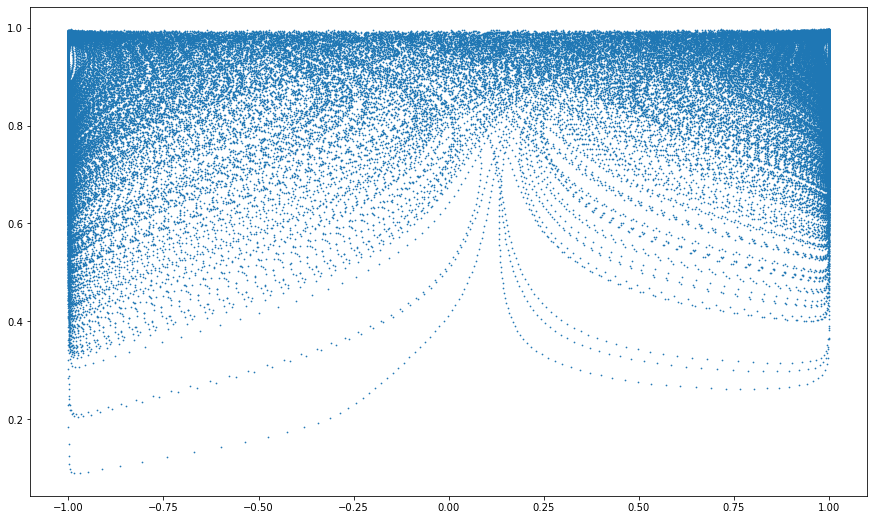

In [25]:
plt.figure(figsize=(15, 9))
# plt.plot(res_results[:, 5])
# plt.plot(res_results[1000:-1000, 50], res_results[1000:-1000, 76], linewidth=0.3)
plt.scatter(res_results[1000:-1000, 53], res_results[1000:-1000, 52], s=0.5)

### PCA on reservoir states:

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(res_results)
X = pca.transform(res_results)
print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.89430941 0.09141061 0.00928027]
[4661.74817278 1490.4013046   474.88143114]


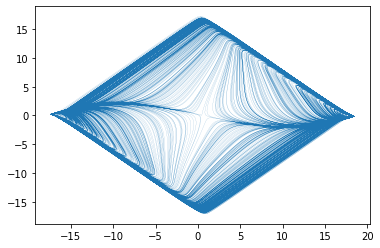

In [29]:
plt.plot(X[1000:, 0], X[1000:, 1], linewidth=0.1)

In [ ]:
# sloap, N_r = rescomp.measures.dimension(X[1000:, :], return_neighbours=True, nr_steps=10)
sloap, N_r = rescomp.measures.dimension(res_results, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

plt.legend()

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [13]:
# Lorenz 96 parameters:
dt_L96 = 0.01
dims_L96 = 60
np.random.seed(1)
starting_point_L96 = np.random.randn(dims_L96)

In [14]:
# Lorenz96 iterator:

_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

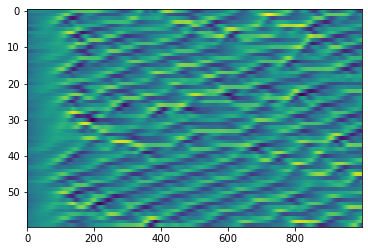

In [15]:
time_steps_L96 = 1000
results_L96 = np.zeros((time_steps_L96, dims_L96))

results_L96[0, :] = starting_point_L96
for i in range(1, time_steps_L96):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")

# Reservoir:

In [180]:
import tensorflow as tf
from keras.layers import AveragePooling1D, Conv1D, InputLayer
from keras.models import Sequential
import networkx as nx

np.random.seed(2)

# Parameters:
time_steps = 10000
disc_timesteps = 100

# reservoir:
dims = [1000, 800, 500]
convs = [dims_L96, int(dims_L96 / 2), int(dims_L96/4)]
print(convs)

model1 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=1, strides=1, padding='same')
])
def f1(x):
    return model1.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96))

model2 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=2, strides=2, padding='same')
])
def f2(x):
    return model2.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/2))

model3 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=4, strides=4, padding='same')
])
def f3(x):
    return model3.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/4))

pools = [f1, f2, f3]

w_in_scale = 0.5
w_ins = []
for i in range(3):
    w_in = np.random.uniform(low=-w_in_scale,
                             high=w_in_scale,
                             size=(dims[i], convs[i]))
    w_ins.append(w_in)

edge_prob = 0.01
Ws = []
for i in range(3):
    W = nx.to_numpy_array(nx.fast_gnp_random_graph(dims[i], edge_prob,seed=np.random))
    Ws.append(W)

res_states = []
for i in range(3):
    res_state = np.zeros((time_steps, dims[i]))
    res_state[0, :] = np.random.randn(dims[i])
    res_states.append(res_state)

[60, 30, 15]


In [181]:
starting_point_L96_use = starting_point_L96
starting_point_L_use = starting_point_L

# discard the starting timesteps:
for i in range(disc_timesteps):
    starting_point_L96_use = f_L96(starting_point_L96_use)
    starting_point_L_use = f_L(starting_point_L_use)

In [182]:
# L96
results_L96 = np.zeros((time_steps, dims_L96))
results_L96[0, :] = starting_point_L96_use

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

##  Run RC:

In [183]:
# f = lambda x: np.tanh(x)
# f = lambda x: 0.1*x
# f = lambda x: np.heaviside(x,1)
f = lambda x: 1/(1+np.exp(-x))

for i in range(1, time_steps):
    x_last_in = results_L96[i - 1, :]

    x_last_res1 = res_states[0][i - 1, :]
    x_last_res2 = res_states[1][i - 1, :]
    x_last_res3 = res_states[2][i - 1, :]

    for k in range(3):
        x_last_res =  res_states[k][i - 1, :]

        # apply pooling:
        x_last_in_pool = pools[k](x_last_in)
        # print(x_last_in_pool.shape)
        # print(w_ins[k].shape)
        # coupl pooled input with reservoir
        inp =  w_ins[k].dot(x_last_in_pool) + Ws[k].dot(x_last_res)
        res_states[k][i, :] = f(inp)
    results_L96[i, :] = f_L96(x_last_in)

## Plot Reservoir quantities:

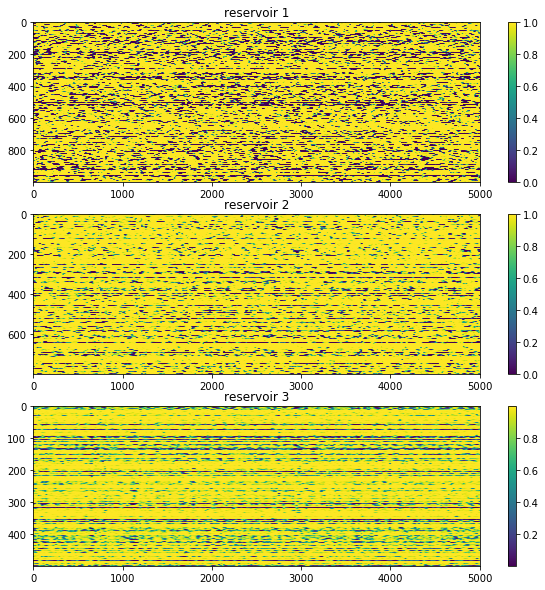

In [184]:
xlim = (0,5000)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for k in range(3):
    ax = axs[k]
    im = ax.imshow(res_states[k][1:, :].T, aspect="auto")
    ax.set_xlim(xlim)
    ax.set_title(f"reservoir {k+1}")
    fig.colorbar(im, ax=ax, orientation='vertical')

(0, 0.1)

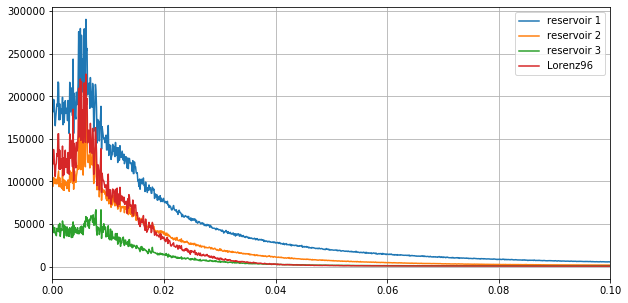

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for k in range(3):
    x, y = rescomp.measures.fourier_spectrum(res_states[k])
    ax.plot(x, y, label=f"reservoir {k+1}")


x, y = rescomp.measures.fourier_spectrum(results_L96)
ax.plot(x, y, label="Lorenz96")

ax.grid()
ax.legend()
ax.set_xlim(0, 0.1)

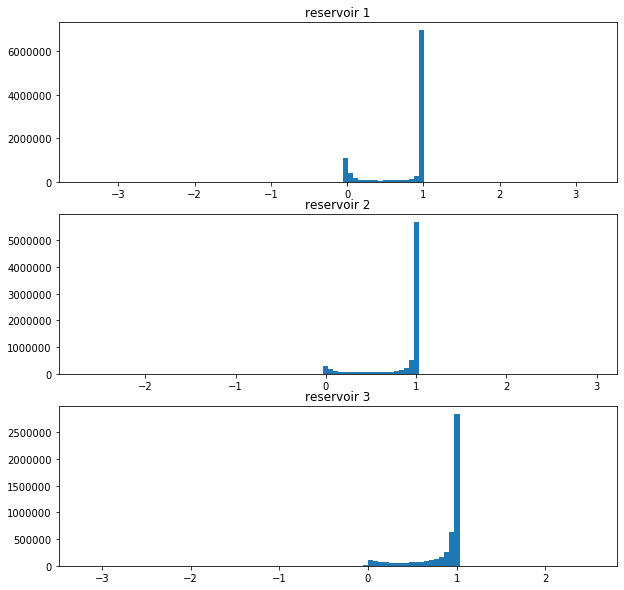

In [186]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for k in range(3):
    ax = axs[k]
    ax.hist(res_states[k].flatten(), bins=100)
    ax.set_title(f"reservoir {k+1}")

## Train and Test:

In [187]:
from sklearn.linear_model import Ridge, LogisticRegression
# Try to fit the coupled to the output:
sync_steps = 500
train_steps = 8000
test_steps = 1500


y_sync = results_L96[: sync_steps, :]

y_train = results_L96[sync_steps: sync_steps + train_steps, :]

y_test = results_L96[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

y_test_pred_list = []

for k in range(3):
    x_sync = res_states[k][: sync_steps, :]
    x_train = res_states[k][sync_steps: sync_steps + train_steps, :]
    x_test = res_states[k][sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
    # Train:
    model = Ridge(alpha=0.005)
    model.fit(x_train, y_train)

    y_test_pred = model.predict(x_test)
    y_test_pred_list.append(y_test_pred)

all_together = np.concatenate(res_states, axis=-1)
x_sync = all_together[: sync_steps, :]
x_train = all_together[sync_steps: sync_steps + train_steps, :]
x_test = all_together[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
# Train:
model = Ridge(alpha=0.005)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred_list.append(y_test_pred)

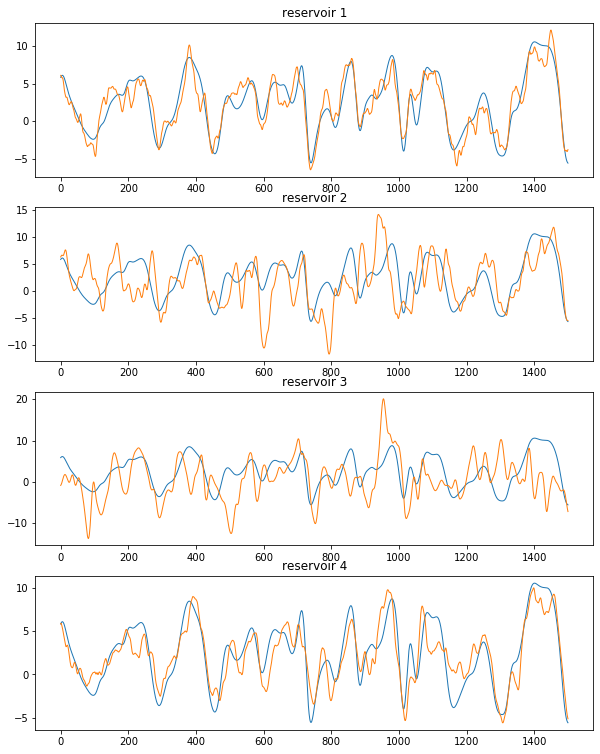

In [188]:
axis = 5

fig, axs = plt.subplots(4, 1, figsize=(10, 13))
for k in range(4):
    y_test_pred = y_test_pred_list[k]
    ax = axs[k]
    ax.plot(y_test[:, axis], linewidth=1)
    ax.plot(y_test_pred[:, axis], linewidth=1)
    ax.set_title(f"reservoir {k+1}")
